In [14]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.metrics import accuracy_score

In [15]:
#import the data
data = pd.read_csv("https://raw.githubusercontent.com/afnanrahman/EAFP/main/data/clean_smote_data.csv")
data

,age,business_travel,daily_rate,department,distance_from_home,education,education_field,employee_number,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_rate,num_companies_worked,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_with_curr_manager,attrition,rate_avg
0,41,2,1102,2,1,2,1,1,2,0,94,3,2,7,4,2,19479,8,1,11,3,1,0,8,0,1,6,4,5,1,6891.67
1,49,1,279,1,8,1,1,2,3,1,61,2,2,6,2,1,24907,1,0,23,4,4,1,10,3,3,10,7,7,0,8415.67
2,37,2,1373,1,2,2,4,4,4,1,92,2,1,2,3,2,2396,6,1,15,3,2,0,7,3,3,0,0,0,1,1287.00
3,33,1,1392,1,3,4,1,5,4,0,56,3,1,6,3,1,23159,1,1,11,3,3,0,8,3,3,8,7,0,0,8202.33
4,27,2,591,1,2,1,3,7,1,1,40,3,1,2,2,1,16632,9,0,12,3,4,1,6,3,3,2,2,2,0,5754.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2461,39,2,1053,1,7,2,2,1160,1,0,72,1,1,0,1,1,14504,4,0,13,3,1,0,12,2,2,1,0,0,1,5209.67
2462,32,0,453,1,11,2,3,998,3,1,43,2,1,4,1,1,10219,0,1,22,4,2,0,4,0,2,3,2,2,1,3571.67
2463,34,2,489,1,7,3,2,1729,3,1,59,2,2,4,1,1,5098,1,0,13,3,2,0,10,4,1,10,4,7,1,1882.00
2464,36,2,237,1,18,3,1,1080,1,0,49,2,1,5,2,1,11643,4,1,11,3,2,0,12,1,2,6,3,2,1,3976.33


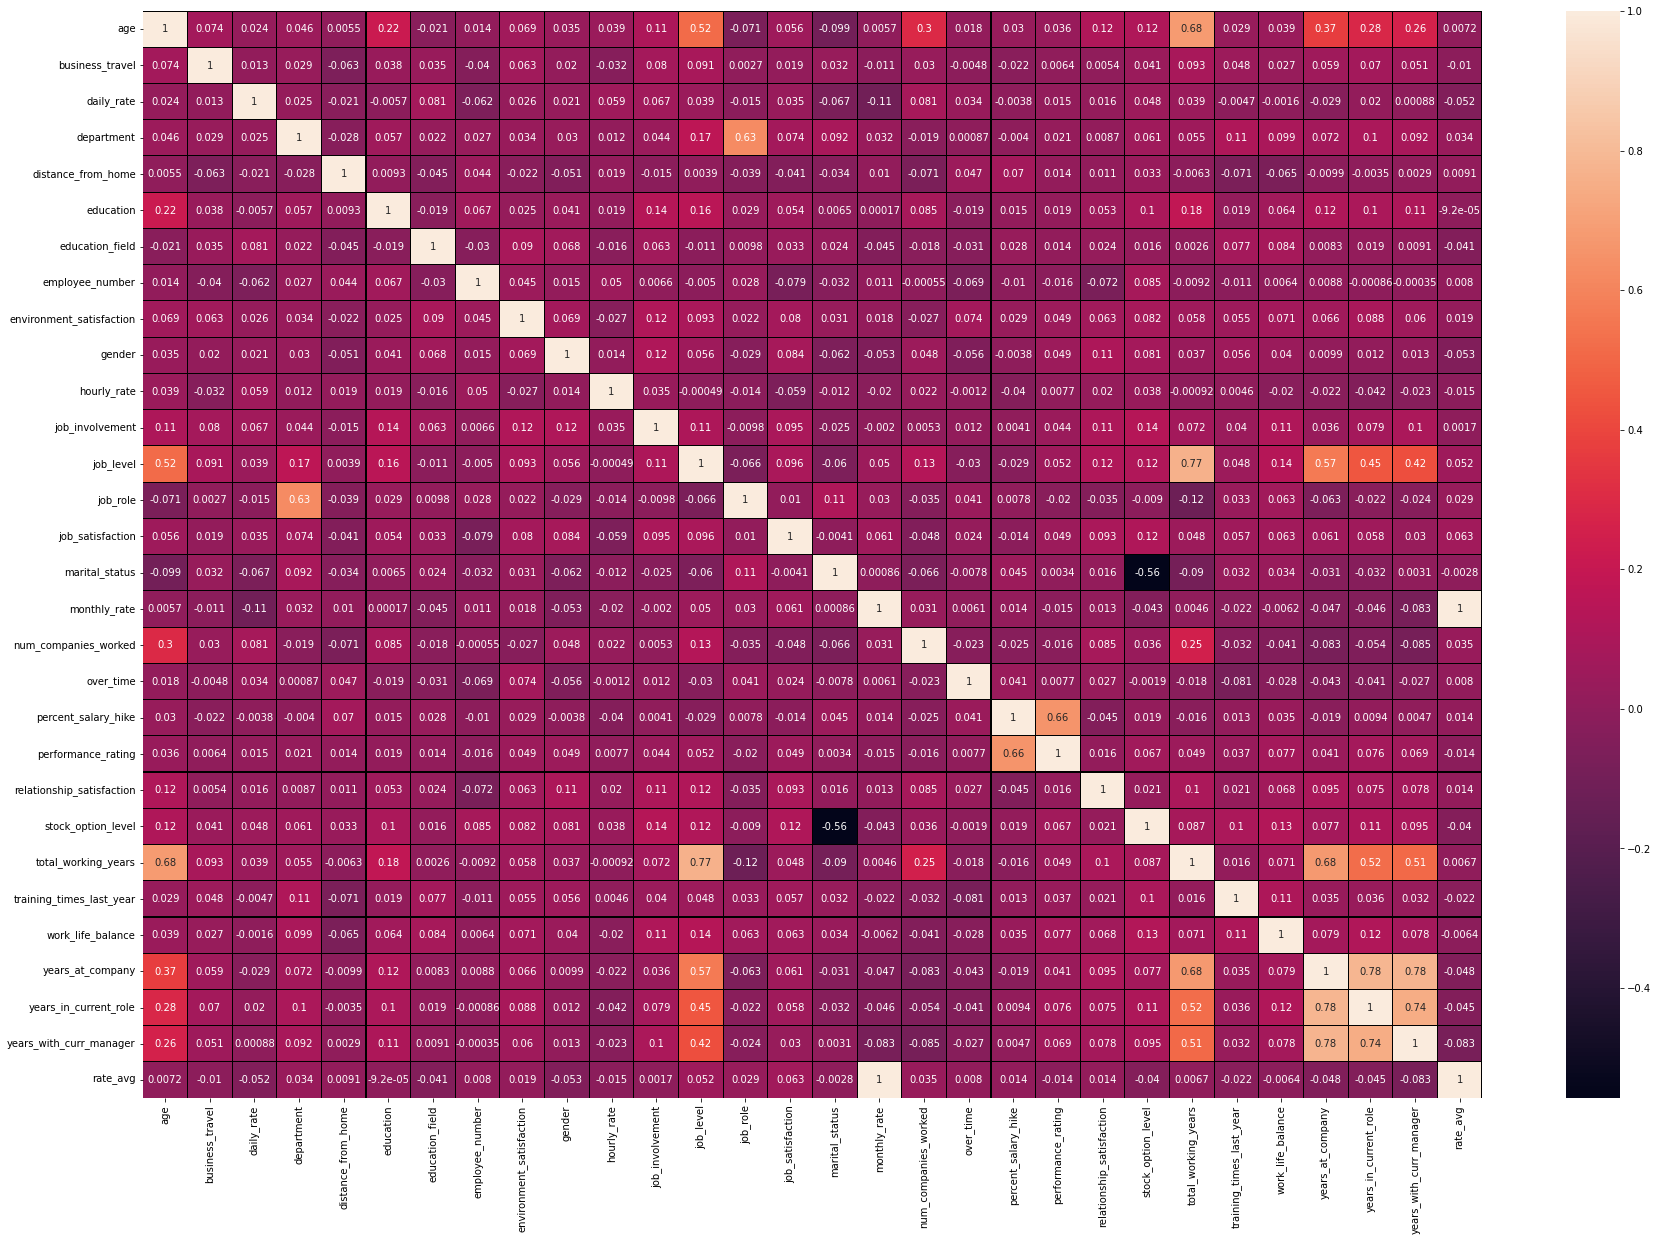

In [16]:
no_attr = data.drop('attrition', axis=1)
plt.figure(figsize=(30,20))
sns.heatmap(no_attr.corr(), annot=True, linewidths=0.1, linecolor='black')

In [17]:
X = data.drop('attrition', axis=1)
y = data['attrition']

print(X)

print(y)

# Get indeces with max correlation between each other
f_values = np.array(f_regression(X,y)[0])
max_index = f_values.argsort()

print(max_index)


all_cols = list(X.columns)
remove_cols = ['total_working_years', 'years_at_company', 'percent_salary_hike',
               'years_with_curr_manager', 'hourly_rate', 'daily_rate', 
               'monthly_rate']
            

#this is called List Comprehension if you havent' seen it before
#it's a very powerful tool in Python and I would suggest you read up on it 
#if you want to work on your Python skills
no_corr_cols = [x for x in all_cols if x not in remove_cols]

X = data[no_corr_cols]

# for i in range(8):
#   index = max_index[i] - 2
#   print(X.columns[index])
#   X.drop(X.columns[index], axis=1, inplace=True)

# print(X)

# select = SelectKBest(score_func=f_regression, k=5)

# X_train_select = select.fit_transform(X, Y)

# print(X_train_select)


      age  business_travel  ...  years_with_curr_manager  rate_avg
0      41                2  ...                        5   6891.67
1      49                1  ...                        7   8415.67
2      37                2  ...                        0   1287.00
3      33                1  ...                        0   8202.33
4      27                2  ...                        2   5754.33
...   ...              ...  ...                      ...       ...
2461   39                2  ...                        0   5209.67
2462   32                0  ...                        2   3571.67
2463   34                2  ...                        7   1882.00
2464   36                2  ...                        2   3976.33
2465   32                2  ...                        1   4212.00

[2466 rows x 30 columns]
0       1
1       0
2       1
3       0
4       0
       ..
2461    1
2462    1
2463    1
2464    1
2465    1
Name: attrition, Length: 2466, dtype: int64
[17  7 29 16 13 

In [18]:
# k-fold cross validation stuff

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=5, random_state=42, shuffle=True)

In [35]:
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE

lr_accuracies = []
lr_precisions = []
lr_recall = []
lr_f1_score = []

for train_index, test_index in kfold.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
      y_train, y_test = y[train_index], y[test_index]

      #feature selection here using selectKBest (Filter Method)
      select = SelectKBest(score_func=f_classif, k=19)
      X_train_select_filter = select.fit_transform(X_train, y_train)

      X_test_select_filter = select.transform(X_test)
      logistic_regression_model = LogisticRegression(max_iter = 10000, C=1, penalty='l1', solver='liblinear')
      logistic_regression_model.fit(X_train_select_filter, y_train)

      y_pred_lr = logistic_regression_model.predict(X_test_select_filter)

      # feature selection here using
      # rfe = RFE(estimator=logistic_regression_model, n_features_to_select=19, step=1)
      # rfe.fit_transform(X_train, y_train)
      # rfe.get_feature_names_out(no_corr_cols)
      # feat_cols = rfe.get_support(indices=True)
      # print(rfe)


      # evaluate predictions
      accuracy_lr = round(accuracy_score(y_test, y_pred_lr), 4) # good for current data set
      lr_accuracies.append(round(accuracy_lr, 4))

      precision = precision_score(y_test, y_pred_lr) #good for imbalanced data sets => ours is likely this but since our dataset is balanced manually maybe not
      lr_precisions.append(round(precision,4))

      recall = recall_score(y_test, y_pred_lr)
      lr_recall.append(round(recall,4))

      f1 = f1_score(y_test, y_pred_lr) #punishes outliers more ?
      lr_f1_score.append(round(f1,4))

      
print("Accuracies:" , lr_accuracies )
print("Precisions:" , lr_precisions)
print("Recalls:", lr_recall)
print("f1_scores:" , lr_f1_score)

Accuracies: [0.8057, 0.8398, 0.8296, 0.8316, 0.8235]
Precisions: [0.8058, 0.823, 0.8462, 0.8048, 0.8405]
Recalls: [0.7992, 0.8475, 0.8196, 0.8559, 0.8244]
f1_scores: [0.8025, 0.8351, 0.8327, 0.8296, 0.8324]


In [36]:
print("Accuracy: %.2f%%" % (np.mean(lr_accuracies)*100)) #82.60 (50), 82.64 (5), 82.60 (1), 82.73 (0)
print("Precisions: %.2f%%" % (np.mean(lr_precisions)*100)) #82.41 (50), 82.42 (5), 82.45 (1), 82.50 (0)
print("Recall: %.2f%%" % (np.mean(lr_recall)*100)) #82.93 (50), 83.01 (5), 82.83 (1), 83.09 (0)
print("f1_score: %.2f%%" % (np.mean(lr_f1_score)*100)) #82.65 (50), 82.69 (5), 82.62 (1), 82.77 (0)

Accuracy: 82.60%
Precisions: 82.41%
Recall: 82.93%
f1_score: 82.65%


In [21]:
from sklearn.metrics import confusion_matrix
labels = ['No Attrition', 'Attrition']
cm = confusion_matrix(y_test, y_pred_lr)
print(cm)

[[190  41]
 [ 45 217]]


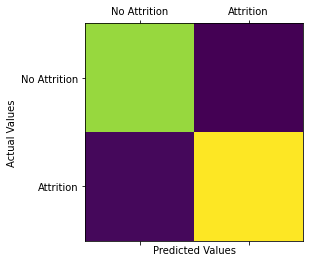

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

AUC - Test Set: 82.54%


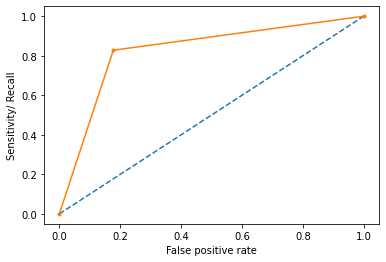

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

auc = roc_auc_score(y_test, y_pred_lr)
print('AUC - Test Set: %.2f%%' % (auc*100))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)

plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('Sensitivity/ Recall')
# show the plot
plt.show()